# Google Images Scraping for Dataset Creation
This code is used to generate mainly datasets with labeled images. 

This code is configured to run over Google Colab

## Requried Libraries 

In [4]:
import os
import time
import requests
import io
import hashlib
from PIL import Image
import signal
from glob import glob

In [5]:
# setting up webdriver
# Selenium WebDriver is a collection of open source APIs which are used to automate the testing of a web application
# this setup is suitable for Google Colab 
!pip install selenium
!apt-get update 
!apt install chromium-chromedriver

!cp /usr/lib/chromium-browser/chromedriver /usr/bin
import sys
from selenium import webdriver
sys.path.insert(0,'/usr/lib/chromium-browser/chromedriver')

     |████████████████████████████████| 904 kB 5.2 MB/s 
Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:4 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Ign:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:6 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:11 http://security.ubuntu.com/ubuntu bionic-security/universe amd64 Packages [1,430 kB]
Hit:12 http://ppa.launchpa

## Required Dataset Setup
Identify all labels to collect images for

labels can contaion spaces if two words or more is used

Also, the labels can be a caption (suitable to be used for Google Images search) 

In [6]:
'''labels = ['Aardvark', 'Alligator', 'Alpaca', 'Anaconda', 'Ant', 'Antelope', 'Ape', 'Aphid', 'Armadillo', 'Asp', 'Baboon', 'Badger', 'Bald Eagle', 'Barracuda', 'Bass', 'Basset Hound', 'Bat', 'Bear', 'Beaver', 'Bedbug', 'Bee', 'Beetle', 'Bird', 'Bison', 'Black panther', 'Black Widow Spider',
'Blue Jay', 'Blue Whale', 'Bobcat', 'Buffalo', 'Butterfly', 'Buzzard', 'Camel', 'Caribou', 'Carp', 'Cat', 'Caterpillar', 'Catfish', 'Cheetah', 'Chicken', 'Chimpanzee', 'Chipmunk', 'Cobra', 'Cod', 'Condor',
'Cougar', 'Cow', 'Coyote', 'Crab', 'Crane', 'Cricket', 'Crocodile', 'Crow', 'Cuckoo', 'Deer', 'Dinosaur', 'Dog', 'Dolphin', 'Donkey', 'Dove', 'Dragonfly', 'Duck', 'Eagle', 'Eel', 'Elephant', 'Emu', 'Falcon', 'Ferret', 'Finch', 'Fish', 'Flamingo',
'Flea', 'Fly', 'Fox', 'Frog', 'Goat', 'Goose', 'Gopher', 'Gorilla', 'Grasshopper', 'Hamster', 'Hare', 'Hawk', 'Hippopotamus', 'Horse', 'Hummingbird', 'Humpback Whale', 'Husky', 'Iguana', 'Impala', 'Kangaroo', 'Ladybug', 'Leopard', 'Lion', 'Lizard',
'Llama', 'Lobster', 'Mongoose', 'Monitor lizard', 'Monkey', 'Moose', 'Mosquito', 'Moth', 'Mountain goat', 'Mouse', 'Mule', 'Octopus', 'Orca', 'Ostrich', 'Otter', 'Owl', 'Ox', 'Oyster', 'Panda', 'Parrot', 'Peacock', 'Pelican', 'Penguin', 'Perch', 'Pheasant'
'Pig', 'Pigeon', 'Polar bear', 'Porcupine', 'Quail', 'Rabbit', 'Raccoon', 'Rat', 'Rattlesnake', 'Raven', 'Rooster', 'Sealion', 'Sheep', 'Shrew', 'Skunk', 'Snail', 'Snake', 'Spider', 'Tiger', 'Walrus', 'Whale', 'Wolf', 'Zebra']
'''
labels = ['Aardvark', 'Alligator', 'Alpaca'] # small sample for this demo
print(len(labels))

number_images_per_label = 20
dataset_path = "/content/drive/MyDrive/..." # select your Google Drive path here
dataset_path = "/content/drive/MyDrive/Colab-Notebooks/data-analytics-projects/GoogleImagesDatasetScraping/output_dataset"
# you need to connect your Google Drive to Google Colab and get the directory 

3


## Google Images Scraping
Scrape Google Images and download the dataset to your dataset_path in Google Drive (or local directory)

In [7]:
search_terms = labels
output_path = dataset_path

number_of_images = number_images_per_label
GET_IMAGE_TIMEOUT = 2
SLEEP_BETWEEN_INTERACTIONS = 0.1
SLEEP_BEFORE_MORE = 5

# Get terms already recorded.
dirs = glob(output_path + "*")
dirs = [dir.split("/")[-1].replace("_", " ") for dir in dirs]

# Exclude terms already stored.
search_terms = [term for term in search_terms if term not in dirs]

##########
# Scrap
##########
chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--headless')
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')
wd = webdriver.Chrome('chromedriver', options=chrome_options)
wd.get("https://google.com")

# Credit:
# https://stackoverflow.com/a/22348885
class timeout:
    def __init__(self, seconds=1, error_message="Timeout"):
        self.seconds = seconds
        self.error_message = error_message

    def handle_timeout(self, signum, frame):
        raise TimeoutError(self.error_message)

    def __enter__(self):
        signal.signal(signal.SIGALRM, self.handle_timeout)
        signal.alarm(self.seconds)

    def __exit__(self, type, value, traceback):
        signal.alarm(0)


def fetch_image_urls(
    query: str,
    max_links_to_fetch: int,
    wd: webdriver,
    sleep_between_interactions: int = 1,
):
    def scroll_to_end(wd):
        wd.execute_script("window.scrollTo(0, document.body.scrollHeight);")
        time.sleep(sleep_between_interactions)

    # build the google query
    search_url = "https://www.google.com/search?safe=off&site=&tbm=isch&source=hp&q={q}&oq={q}&gs_l=img"

    # load the page
    wd.get(search_url.format(q=query))

    image_urls = set()
    image_count = 0
    results_start = 0
    while image_count < max_links_to_fetch:
        scroll_to_end(wd)

        # get all image thumbnail results
        thumbnail_results = wd.find_elements_by_css_selector("img.Q4LuWd")
        number_results = len(thumbnail_results)

        print(
            f"Found: {number_results} search results. Extracting links from {results_start}:{number_results}"
        )

        for img in thumbnail_results[results_start:number_results]:
            # try to click every thumbnail such that we can get the real image behind it
            try:
                img.click()
                time.sleep(sleep_between_interactions)
            except Exception:
                continue

            # extract image urls
            actual_images = wd.find_elements_by_css_selector("img.n3VNCb")
            for actual_image in actual_images:
                if actual_image.get_attribute(
                    "src"
                ) and "http" in actual_image.get_attribute("src"):
                    image_urls.add(actual_image.get_attribute("src"))

            image_count = len(image_urls)

            if len(image_urls) >= max_links_to_fetch:
                print(f"Found: {len(image_urls)} image links, done!")
                break
        else:
            print("Found:", len(image_urls), "image links, looking for more ...")
            time.sleep(SLEEP_BEFORE_MORE)

            not_what_you_want_button = ""
            try:
                not_what_you_want_button = wd.find_element_by_css_selector(".r0zKGf")
            except:
                pass

            # If there are no more images return.
            if not_what_you_want_button:
                print("No more images available.")
                return image_urls

            load_more_button = wd.find_element_by_css_selector(".mye4qd")
            if load_more_button and not not_what_you_want_button:
                wd.execute_script("document.querySelector('.mye4qd').click();")

        # move the result startpoint further down
        results_start = len(thumbnail_results)

    return image_urls


def persist_image(folder_path: str, url: str):
    try:
        print("Getting image")
        with timeout(GET_IMAGE_TIMEOUT):
            image_content = requests.get(url).content

    except Exception as e:
        print(f"ERROR - Could not download {url} - {e}")

    try:
        image_file = io.BytesIO(image_content)
        image = Image.open(image_file).convert("RGB")
        file_path = os.path.join(
            folder_path, hashlib.sha1(image_content).hexdigest()[:10] + ".jpg"
        )
        with open(file_path, "wb") as f:
            image.save(f, "JPEG", quality=85)
        print(f"SUCCESS - saved {url} - as {file_path}")
    except Exception as e:
        print(f"ERROR - Could not save {url} - {e}")


def search_and_download(search_term: str, target_path="./images", number_images=5):
    target_folder = os.path.join(target_path, "_".join(search_term.lower().split(" ")))

    if not os.path.exists(target_folder):
        os.makedirs(target_folder)

    with webdriver.Chrome('chromedriver', options=chrome_options) as wd:
        res = fetch_image_urls(
            search_term,
            number_images,
            wd=wd,
            sleep_between_interactions=SLEEP_BETWEEN_INTERACTIONS,
        )

        if res is not None:
            for elem in res:
                persist_image(target_folder, elem)
        else:
            print(f"Failed to return links for term: {search_term}")


for i, term in enumerate(search_terms):
    print(i, term)
    if i >= 0: # if the code break at any point ... you can use this to continue from where the code stops (helpful on Google Colab)
      search_and_download(term, output_path, number_of_images)


0 Aardvark
Found: 100 search results. Extracting links from 0:100
Found: 20 image links, done!
Getting image
SUCCESS - saved https://cdn1.parksmedia.wdprapps.disney.com/media/blog/wp-content/uploads/2020/10/5789uyt554-696x1024.jpg - as /content/drive/MyDrive/Colab-Notebooks/data-analytics-projects/GoogleImagesDatasetScraping/output_dataset/aardvark/c68f68bb1e.jpg
Getting image
SUCCESS - saved https://dnk4skl3hw8rq.cloudfront.net/assets/99ee6fe1112f8bb8252ed859031f73b688910198/aardvark4.content.jpg - as /content/drive/MyDrive/Colab-Notebooks/data-analytics-projects/GoogleImagesDatasetScraping/output_dataset/aardvark/4fd56f0a88.jpg
Getting image
SUCCESS - saved https://i.natgeofe.com/k/f5833e73-0f1c-4bc7-a2bd-d572ca71f6df/aardvark-walking.jpg - as /content/drive/MyDrive/Colab-Notebooks/data-analytics-projects/GoogleImagesDatasetScraping/output_dataset/aardvark/d197d59a0b.jpg
Getting image
SUCCESS - saved https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQwuRI5Bg0JzRSJihqrkC0yFTZ8F5_O

## Unifying Images Dimensions

In [14]:
# listing the created directories:
# making all labels into lower case and replacing space with _ (which mateches what's done by the scrape code)
labels_dir = []
for i, l in enumerate(labels):
    # print(i)
    labels_dir.append(l.replace(' ', '_').lower())
labels_dir

0
1
2


['aardvark', 'alligator', 'alpaca']

In [15]:
# resize all images: 
size_1 = 200
size_2 = 200
for l in labels_dir:
    print(l)
    path = ('{}/{}'.format(dataset_path, l))
    for item in os.listdir(path):
        item = '{}/{}'.format(path, item) # indicate the whole directory for the item 
        if os.path.isfile(item):
            im = Image.open(item)
            f, e = os.path.splitext(item)
            imResize = im.resize((size_1, size_2), Image.ANTIALIAS)
            imResize.save(f + '.jpg', 'JPEG', quality=90)

aardvark
alligator
alpaca


sample size: (200, 200)


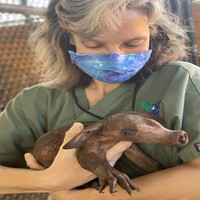

In [33]:
# check if it works:
sample_image_path = '{}/{}'.format(dataset_path, labels_dir[0])
sample_image = os.listdir(sample_image_path)[0]
sample_image = '{}/{}'.format(sample_image_path, sample_image)
im = Image.open(sample_image)
print('sample size:', im.size)
im 